# Section 1: Business Understanding 

## Motivation

This project looks at the popularity of districts in Zurich by analyzing open administrative data provided by the city of Zurich (https://data.stadt-zuerich.ch/). 

Key questions: 
1) Which districts (German: Kreise) do residents of Zurich preferably move to and which districs are unpopular so that residents leave them?
2) Which districts are most popular for newcomers moving to Zurich from outside?
3) Which district sees the most new building projects?

The motivation for this study is that moving in a new district shows an overall preference for this new place after taking into account all factors (availability of housing, public transport connections, local amenities, etc.). For policymakers, understanding those statistics is interesting, because "less popular" districs might need a more favourable treatment to increase popularity, but also "more popular" districs, which receive a higher influx of new residents, might need new policies to accommodate the rising population. 

In [6]:
# Reading in Packages 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import geopandas # for loading shapefile
import imageio # for gif



# Section 2: Data Understanding

In [7]:
# Reading in geodata
shapefile_kreise = 'data/geodata_kreise/stzh.adm_stadtkreise_a.shp'
#shapefile_quartiere = 'data/geodata_quartiere/stzh.adm_vermbezirke_a.shp' # difficult to merge with relocation data

To get started, let's plot a map of the city of Zurich with the districts embedded in it. 

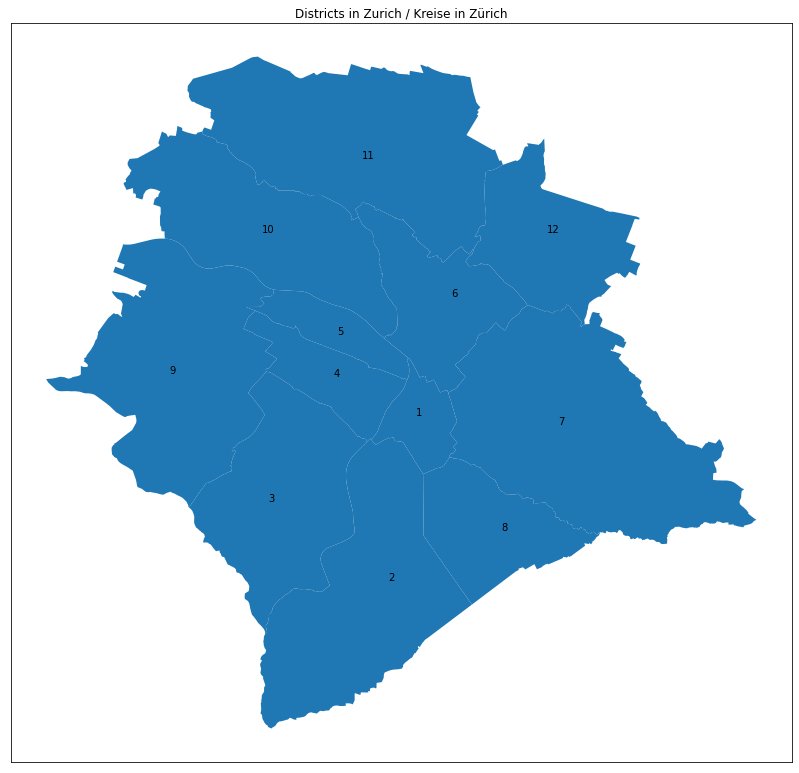

In [8]:
## Converting geodata to plot a map

geo_df = geopandas.read_file(shapefile_kreise)
geo_df.name = geo_df.name.astype('int')
# Compute representative point / coords variable for setting labels
geo_df['coords'] = geo_df['geometry'].apply(lambda x: x.representative_point().coords[:])
geo_df['coords'] = [coords[0] for coords in geo_df['coords']]


# Plot map of Zurich with shapefile and labels

fig, ax = plt.subplots(1, figsize=(14, 14))
ax.set_title('Districts in Zurich / Kreise in Zürich')
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

geo_df.plot(ax = ax)

for idx, row in geo_df.iterrows():
    plt.annotate(text=row['name'], xy=row['coords'],
                 horizontalalignment='center')
    
plt.savefig(f"./results/Zurich_Districts.png")

# Gathering data

Here, three data sets are interesting for us: 

- moving statistics of residents in Zurich (when residents move from one district to another)
https://data.stadt-zuerich.ch/dataset/bev_umzuege_jahr_quartier_od3555
- moving statistics of newcomers in Zurich
https://data.stadt-zuerich.ch/dataset/bev_zuz_jahr_quartier_od3511
- data on building activities
https://data.stadt-zuerich.ch/dataset/bau_neubau_whg_bausm_rinh_geb_projstatus_quartier_seit2009_od5011

In [9]:
## Read in data about moves between Districs in Zurich

# For later replication, use static data in Github Repo
#df_residents = pd.read_csv("data/rawdata/Umzuege_Zuerich.csv")
#df_newcomers = pd.read_csv("data/rawdata/Newcomers_Zuerich.csv")
#df_buildings = pd.read_csv("data/rawdata/Buildings_Zuerich.csv")

df_residents = pd.read_csv("https://data.stadt-zuerich.ch/dataset/bev_umzuege_jahr_quartier_od3555/download/BEV355OD3555.csv")
df_newcomers = pd.read_csv("https://data.stadt-zuerich.ch/dataset/bev_zuz_jahr_quartier_od3511/download/BEV351OD3511.csv")
df_buildings = pd.read_csv("https://data.stadt-zuerich.ch/dataset/bau_neubau_whg_bausm_rinh_geb_projstatus_quartier_seit2009_od5011/download/BAU501OD5011.csv")

# Assessing the data, a first look

In [10]:
print(df_residents.head())
print(df_residents.info())

   StichtagDatJahr  QuarBisherSort  QuarBisherCd QuarBisherLang  \
0             2021              11            11        Rathaus   
1             2021              11            11        Rathaus   
2             2021              11            11        Rathaus   
3             2021              11            11        Rathaus   
4             2021              11            11        Rathaus   

   KreisBisherCd  QuarSort  QuarCd     QuarLang  KreisCd  AnzUmzuWir  
0              1        11      11      Rathaus        1          66  
1              1        12      12  Hochschulen        1           6  
2              1        13      13    Lindenhof        1          14  
3              1        14      14         City        1           4  
4              1        21      21  Wollishofen        2          14  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33524 entries, 0 to 33523
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------      

In [11]:
print(df_newcomers.head())
print(df_newcomers.info())

   StichtagDatJahr  ZuzOrtHistSort  ZuzOrtHistCd   ZuzOrtHistLang  \
0             1993               1             1  Aeugst am Albis   
1             1993               1             1  Aeugst am Albis   
2             1993               1             1  Aeugst am Albis   
3             1993               1             1  Aeugst am Albis   
4             1993               1             1  Aeugst am Albis   

   ZuzBezirkHistSort ZuzBezirkHistLang  ZuzKtHistSort ZuzKtHistLang  \
0                101  Bezirk Affoltern              1        Zürich   
1                101  Bezirk Affoltern              1        Zürich   
2                101  Bezirk Affoltern              1        Zürich   
3                101  Bezirk Affoltern              1        Zürich   
4                101  Bezirk Affoltern              1        Zürich   

   ZuzLandHistSort ZuzLandHistLang  ZuzRegionSort  ZuzRegionLang  \
0             8100         Schweiz             13  Zentraleuropa   
1             8100    

In [12]:
print(df_buildings.head())
print(df_buildings.info())

   Jahr  QuarSort     QuarLang  KreisSort KreisLang      ProjStatus  \
0  2009        11      Rathaus          1   Kreis 1  Fertigerstellt   
1  2009        11      Rathaus          1   Kreis 1          Im Bau   
2  2009        12  Hochschulen          1   Kreis 1          Im Bau   
3  2009        14         City          1   Kreis 1       Bewilligt   
4  2009        14         City          1   Kreis 1          Im Bau   

   ProjAnzGbd  ProjKosten  ProjRauminhalt  ProjAnzWhg  Whg_1_3_Zi  \
0           1           0            1365           3           3   
1           2           0           17690           0           0   
2           5       32000           42700           4           2   
3           1           0          135000           0           0   
4           1           0           17000           0           0   

   Whg_4plus_Zi  
0             0  
1             0  
2             2  
3             0  
4             0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 

### Data Understanding: The Insights

The moving data for newcomers and residents come in similar form (all available from 1993), but are slightly more granular than needed. We need to consolidate the data at the district level and remove the origin (for newcomers) from the data.

Then, we can merge this data and build a dataset where one row corresponds to one district in a given year with the net change of resident movements (subtracting all moveaways from Zurich residents from the number of Zurich residents who moved to this district) and the total number of newcomers from outside.

The building data is only available from 2009. The status tells us whether the new project is already built (Fertigerstellt), currently in progress (Im Bau) or just approved (Bewilligt). We will only look at in progress or finished projects, because an approved project might not necessarily get started. 

## Checking for missing data

# Section 3: Data Preparation

In [13]:
# Data is more granular for residents, group by Kreis / District
df_residents_district = df_residents.groupby(['StichtagDatJahr', 'KreisBisherCd', 'KreisCd'])['AnzUmzuWir'].sum().reset_index()
df_residents_district.columns = ['Year', 'DistrictOrigin', 'DistrictTarget', "Number"]
print(df_residents_district.head())

   Year  DistrictOrigin  DistrictTarget  Number
0  1993               1               1     188
1  1993               1               2      77
2  1993               1               3      94
3  1993               1               4     144
4  1993               1               5      92


In [14]:
# Consolidate to data frame with year district and net change
# First, group by DistrictOrigin to compute the number of ppl who moved away from this district
# and by DistrictTarget to compute the number of people who moved to this district
df_moveaway = df_residents_district.groupby(['Year', 'DistrictOrigin'])['Number'].sum().reset_index()
df_moveaway.columns = ['Year', 'District', 'Number_moveaway']
print(df_moveaway.head())

df_moveto = df_residents_district.groupby(['Year', 'DistrictTarget'])['Number'].sum().reset_index()
df_moveto.columns = ['Year', 'District', 'Number_moveto']
print(df_moveto.head())

# Consolidate the two dataframes from before and compute the net change

df_residents_consolidated = df_moveaway.merge(df_moveto, on=['Year', 'District'])
df_residents_consolidated['NetChangeResidents'] = df_residents_consolidated.Number_moveto - df_residents_consolidated.Number_moveaway
df_residents_consolidated = df_residents_consolidated[['Year', 'District', 'NetChangeResidents']]
print(df_residents_consolidated.head())
print(df_residents_consolidated.info())

   Year  District  Number_moveaway
0  1993         1             1107
1  1993         2             2515
2  1993         3             5636
3  1993         4             5275
4  1993         5             2376
   Year  District  Number_moveto
0  1993         1            914
1  1993         2           2646
2  1993         3           5585
3  1993         4           4940
4  1993         5           2213
   Year  District  NetChangeResidents
0  1993         1                -193
1  1993         2                 131
2  1993         3                 -51
3  1993         4                -335
4  1993         5                -163
<class 'pandas.core.frame.DataFrame'>
Int64Index: 348 entries, 0 to 347
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   Year                348 non-null    int64
 1   District            348 non-null    int64
 2   NetChangeResidents  348 non-null    int64
dtypes: int64(3)
memory u

In [15]:
# Data is more granular for newcomers, group by Kreis / District and take the sum
df_newcomers_district = df_newcomers.groupby(['StichtagDatJahr', 'KreisSort'])['AnzZuzuWir'].sum().reset_index()
df_newcomers_district.columns = ['Year', 'District', 'NumberNewcomers']
print(df_newcomers_district.head())
print(df_newcomers_district.info())

   Year  District  NumberNewcomers
0  1993         1             1390
1  1993         2             2313
2  1993         3             4761
3  1993         4             4524
4  1993         5             1950
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Year             348 non-null    int64
 1   District         348 non-null    int64
 2   NumberNewcomers  348 non-null    int64
dtypes: int64(3)
memory usage: 8.3 KB
None


In [16]:
# Merge newcomers and residents data

df_newcomers_residents_consolidated = df_newcomers_district.merge(df_residents_consolidated, on=['Year', 'District'], how='inner')
print(df_newcomers_residents_consolidated)

     Year  District  NumberNewcomers  NetChangeResidents
0    1993         1             1390                -193
1    1993         2             2313                 131
2    1993         3             4761                 -51
3    1993         4             4524                -335
4    1993         5             1950                -163
..    ...       ...              ...                 ...
343  2021         8             2146                 228
344  2021         9             4544                 499
345  2021        10             2483                 288
346  2021        11             7749                   6
347  2021        12             2274                 301

[348 rows x 4 columns]


# Section 4: Evaluate the Results

## Static Analyis and Visualization

## Question 1: Which district do the residents of Zurich like most? 

In [18]:
# Show changes per district in table 
df_netchange = df_newcomers_residents_consolidated.groupby('District')['NetChangeResidents'].sum().reset_index()
df_netchange.style

,District,NetChangeResidents
0,1,-3385
1,2,8131
2,3,-10058
3,4,-16463
4,5,-4575
5,6,-8139
6,7,1070
7,8,-2836
8,9,11271
9,10,5306


From the table, we can infer that the net change is particularly high for districts 12 and 9, This means that those districts have a positive aggregate change, i.e. stronger inflow from residents in other districts to those districts than the other way round. 

On the other hand, we observe a negative net change for district 4, meaning that more residents moved away from this district than the other way round. 

## Question 2: Which district do the newcomers like most? 

In [19]:
df_newcomers = df_newcomers_residents_consolidated.groupby('District')['NumberNewcomers'].sum().reset_index()
df_newcomers.style

,District,NumberNewcomers
0,1,39808
1,2,80745
2,3,135468
3,4,133461
4,5,51732
5,6,105233
6,7,106159
7,8,62757
8,9,113229
9,10,89638


From the table, we can see that newcomers prefer district 11 (Oerlikon). More than 190k newcomers moved to this district since 1993. 

In [23]:
df_allyears = df_newcomers_residents_consolidated.groupby('District')['NetChangeResidents', 'NumberNewcomers'].sum().reset_index()


/home/michael/Dropbox/Udacity/DataScientist/MediumArticle/Zurich_Popular_Districs/blogpost-venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [31]:
def plot_data_in_map_of_Zurich(df, column_name, column_title, filename):
    """
    """
    fig, ax = plt.subplots(1, figsize=(12, 12))
    ax.set_title(column_title)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    
    cmap = 'inferno'
    vmin = df[column_name].min()
    vmax = df[column_name].max()
    sm_netchange = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)

    df_plot = geo_df.merge(df, right_on='District', left_on="name")
    df_plot.plot(column=column_name, ax=ax, cmap=cmap)



    cbaxes = fig.add_axes([0.15, 0.25, 0.01, 0.4])
    cbar = fig.colorbar(sm_netchange, cax=cbaxes)
    tick_locator = ticker.MaxNLocator(nbins=5)
    cbar.locator = tick_locator
    cbar.update_ticks()

    plt.savefig(f"./results/{filename}")
    
    

'NetChanges_in_Districts_Aggregate.png'

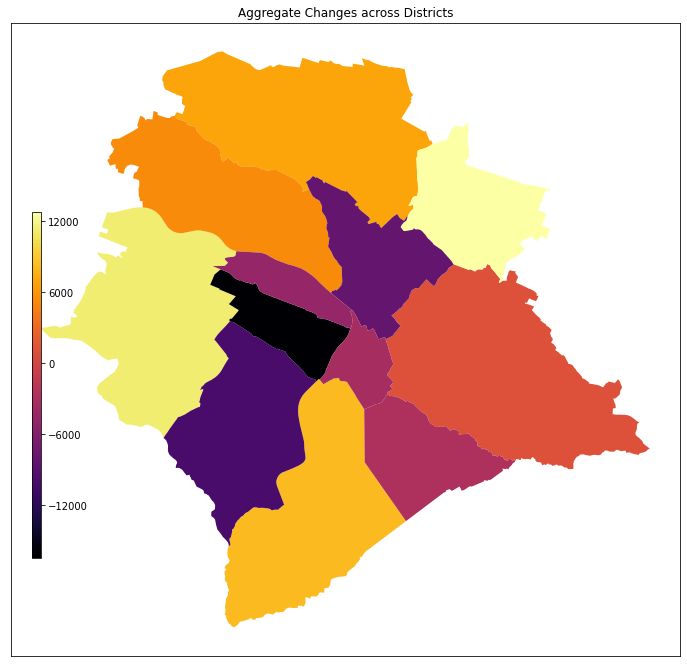

In [30]:
# Visualize aggregate net change

plot_data_in_map_of_Zurich(df = df_allyears, 
                          column_name = 'NetChangeResidents', 
                          column_title = 'Aggregate Changes across Districts',
                          filename = 'NetChanges_in_Districts_Aggregate.png')

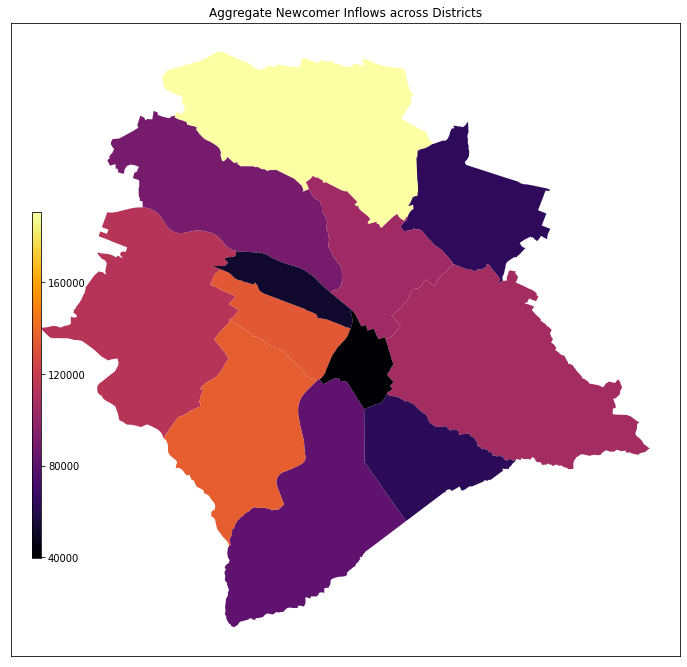

In [32]:
# Visualize aggregate newcomer inflows

plot_data_in_map_of_Zurich(df = df_allyears, 
                          column_name = 'NumberNewcomers', 
                          column_title = 'Aggregate Newcomer Inflows across Districts',
                          filename = 'Newcomers_in_Districts_Aggregate.png')

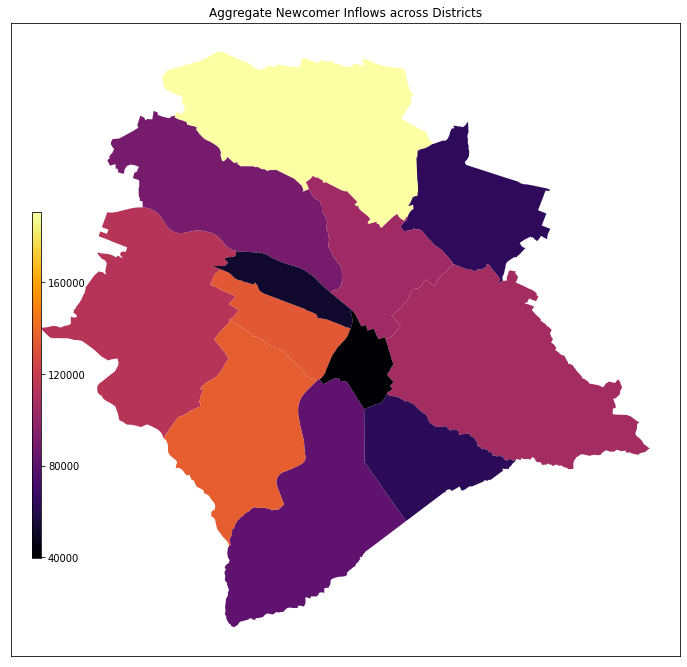

## Dynamic Analysis and Visualization

/home/michael/Dropbox/Udacity/DataScientist/MediumArticle/Zurich_Popular_Districs/blogpost-venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


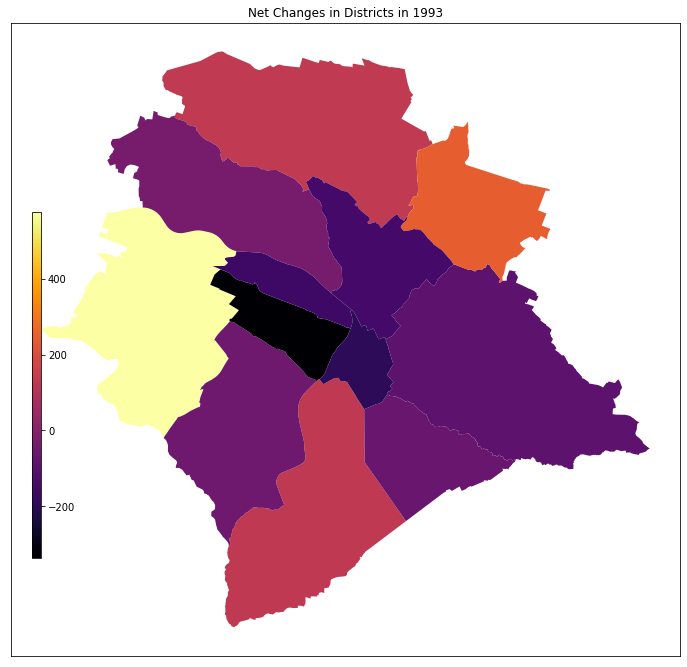

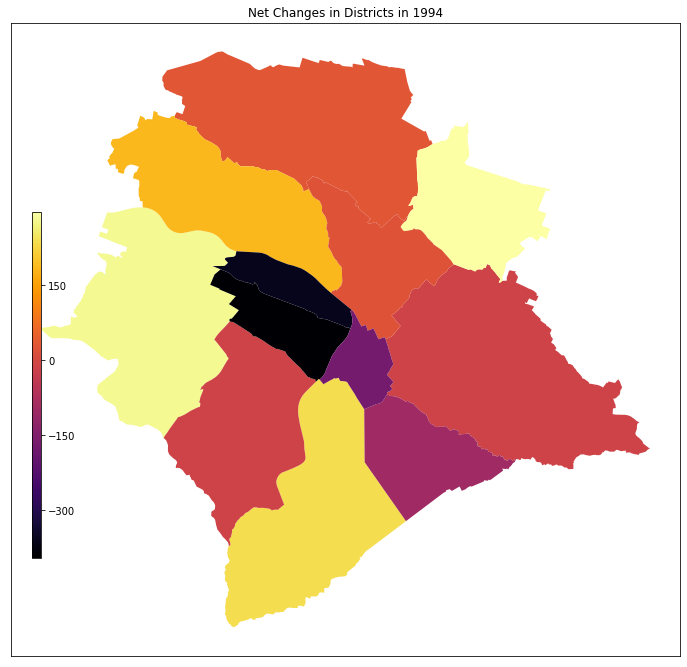

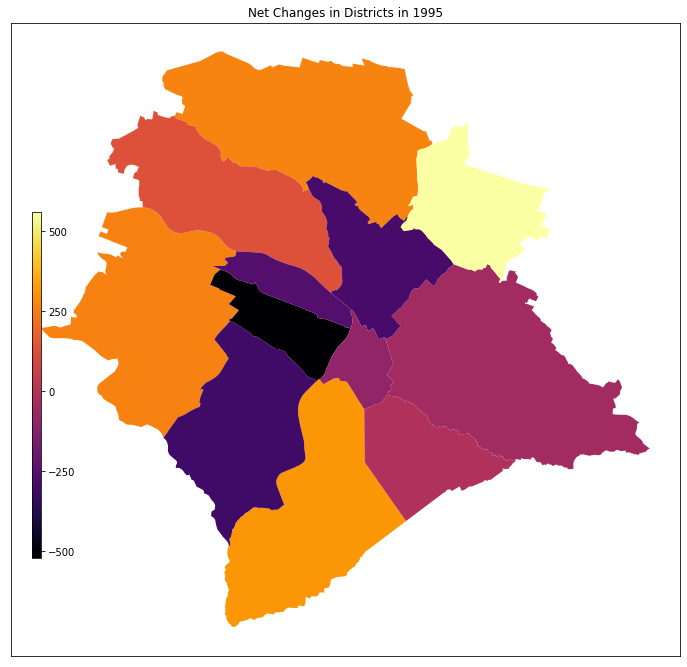

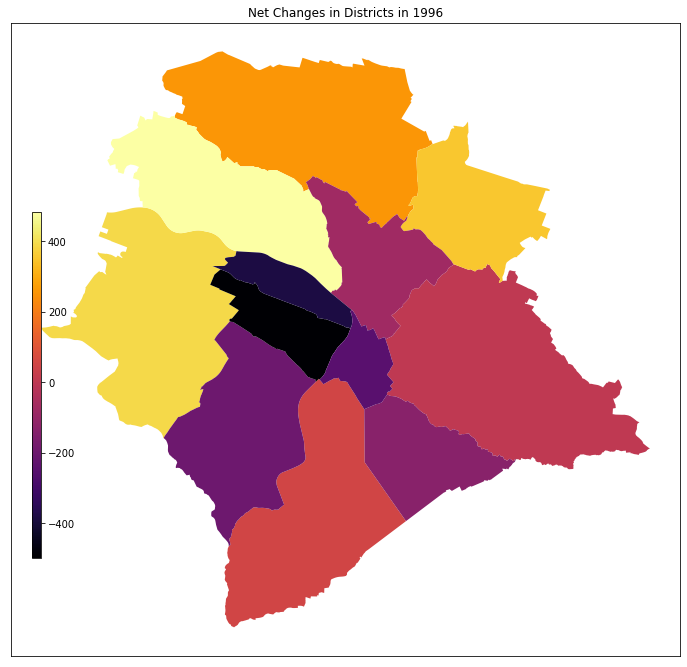

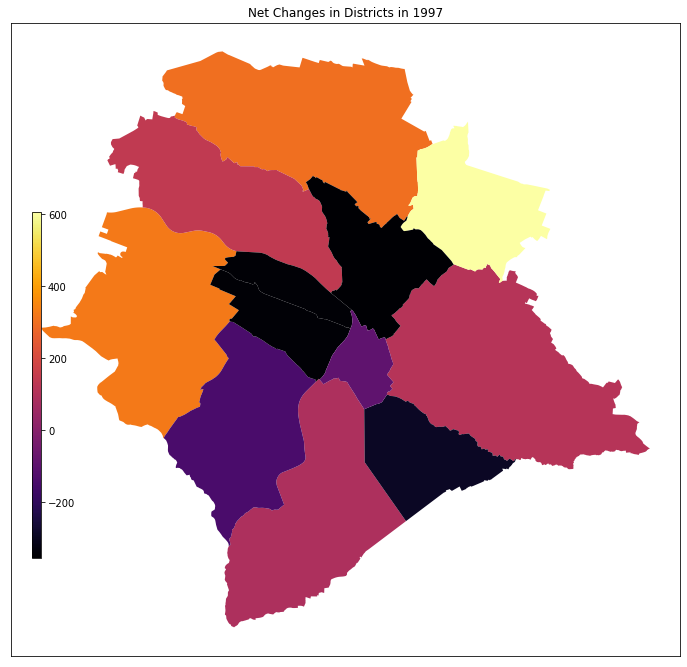

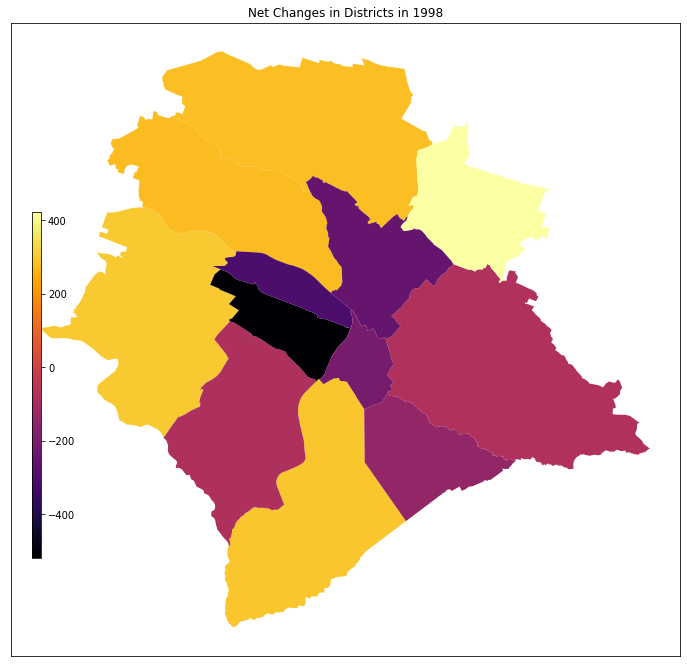

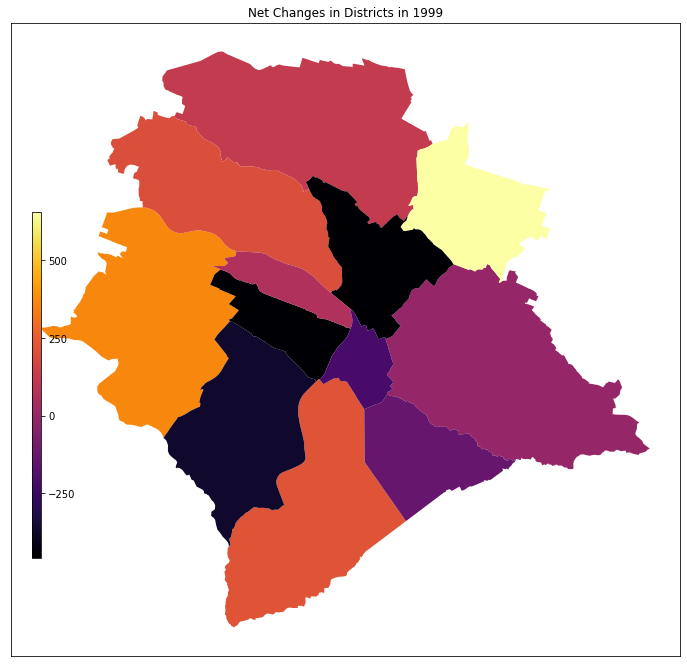

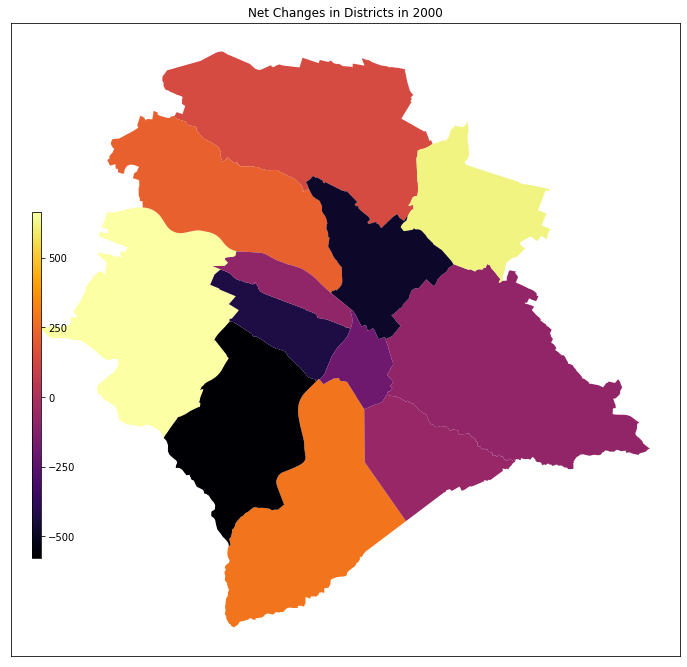

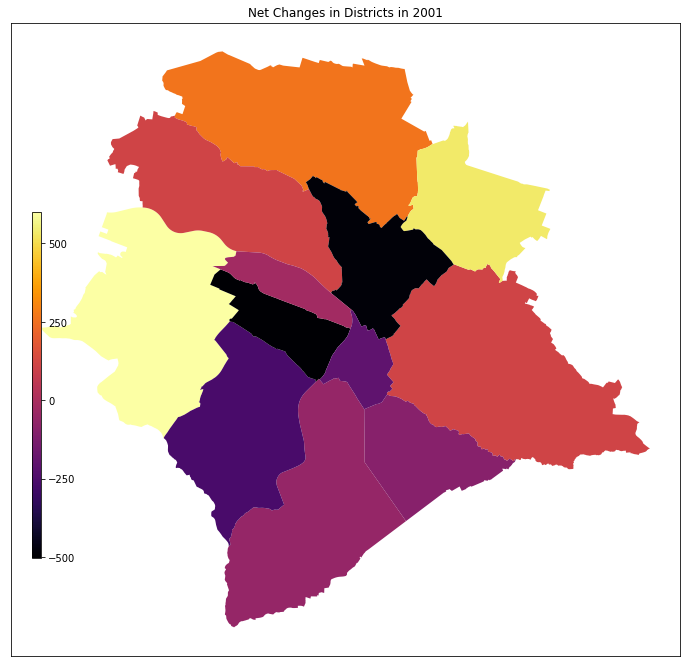

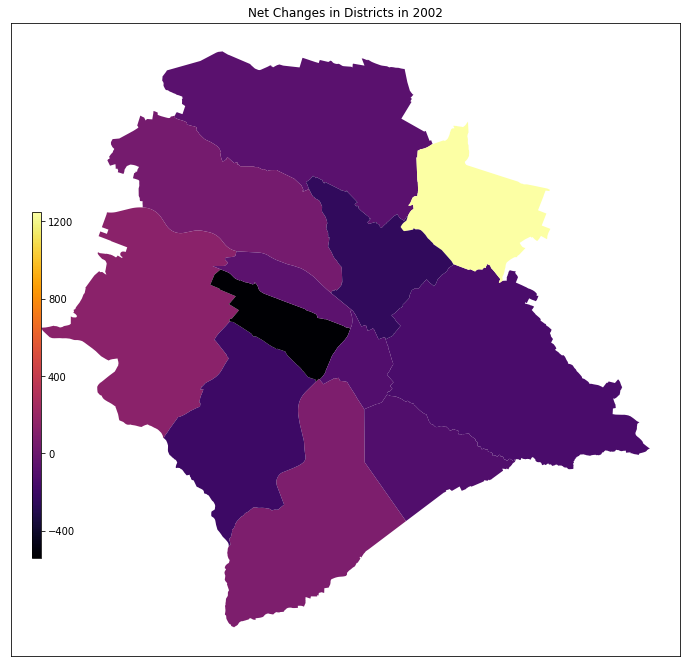

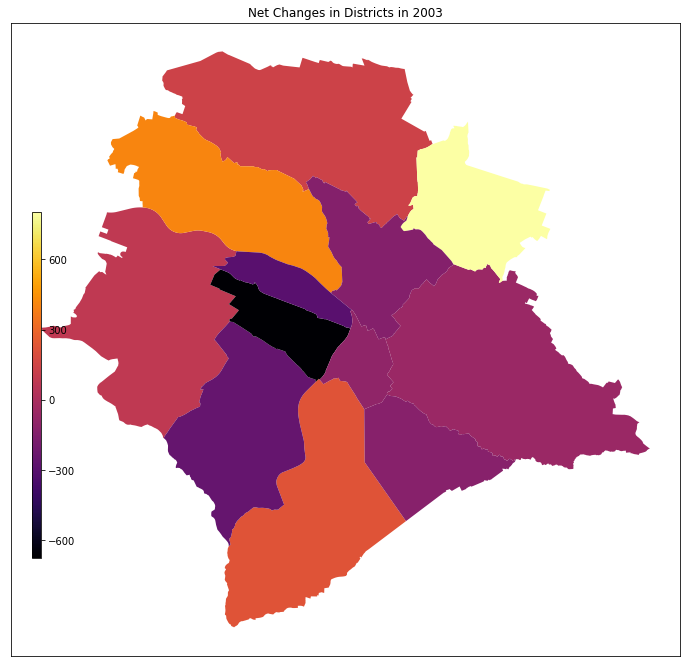

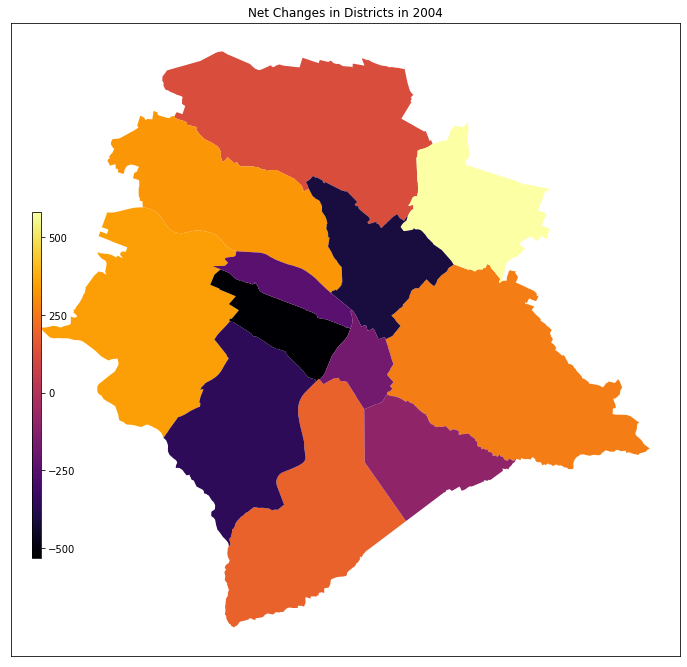

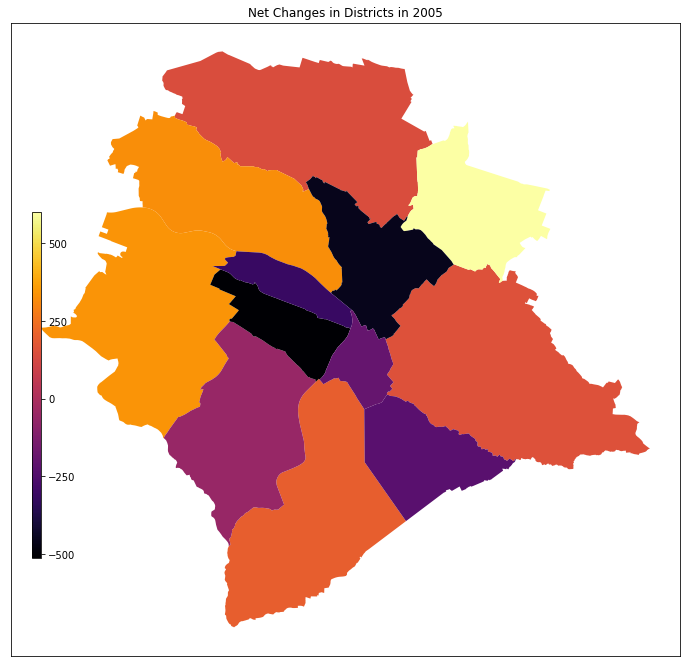

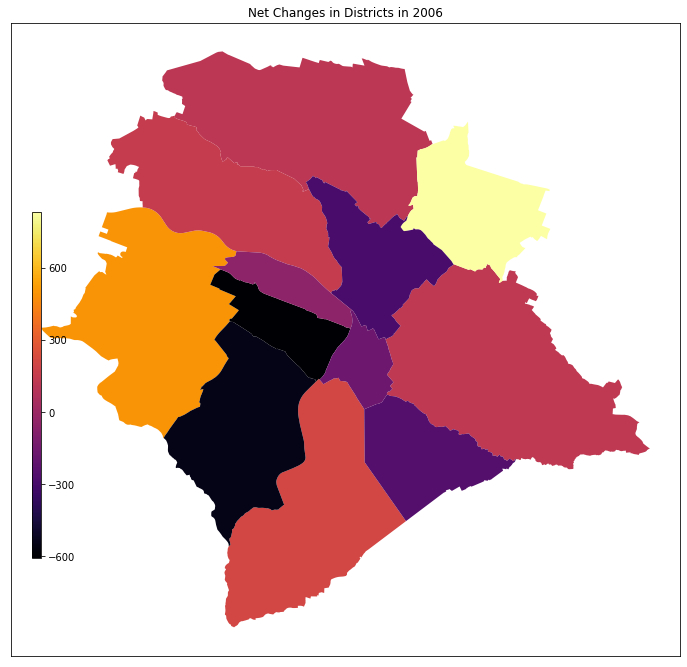

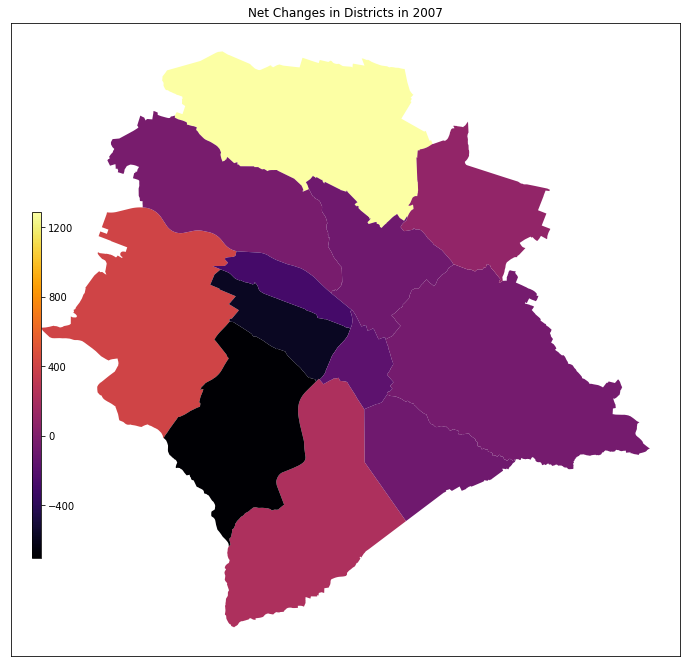

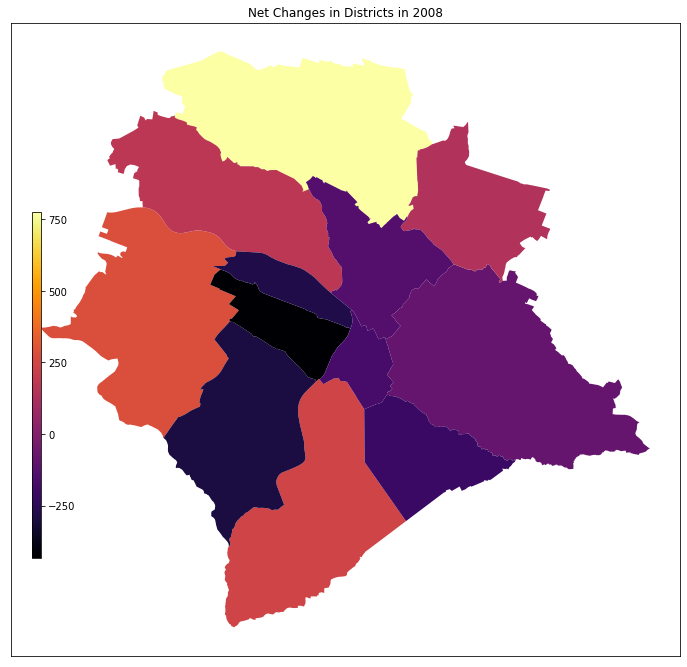

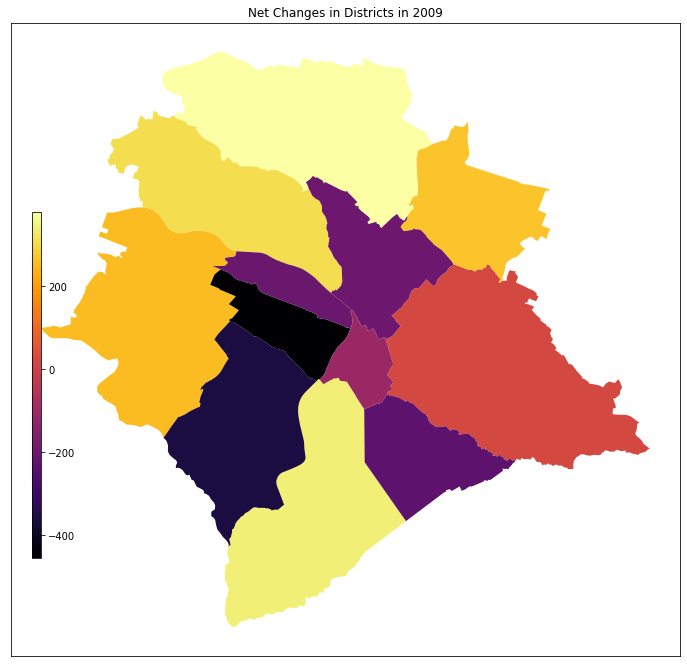

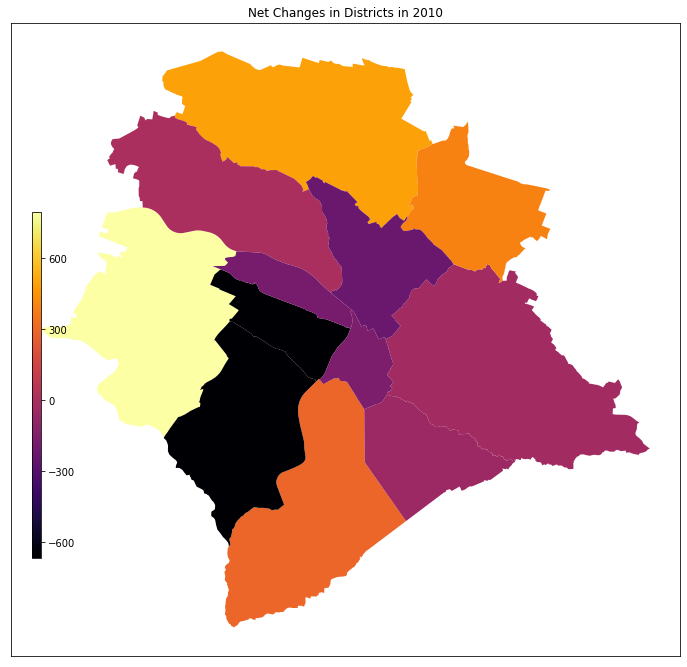

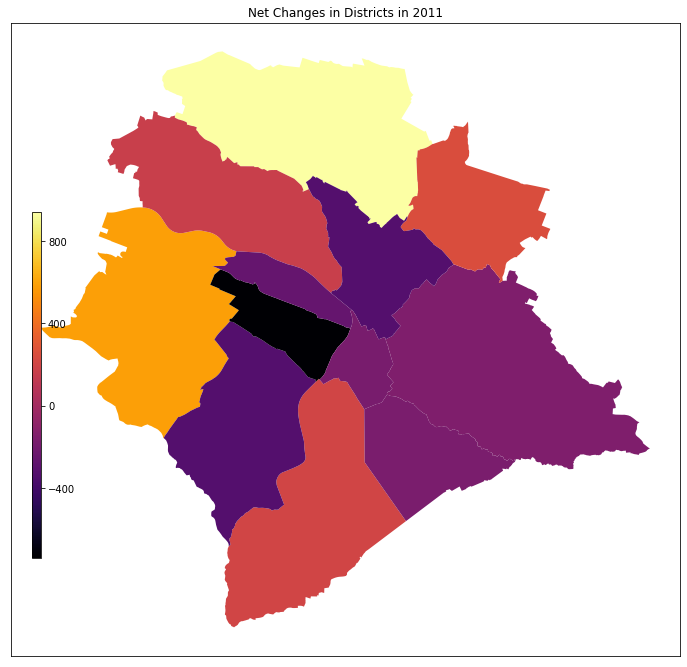

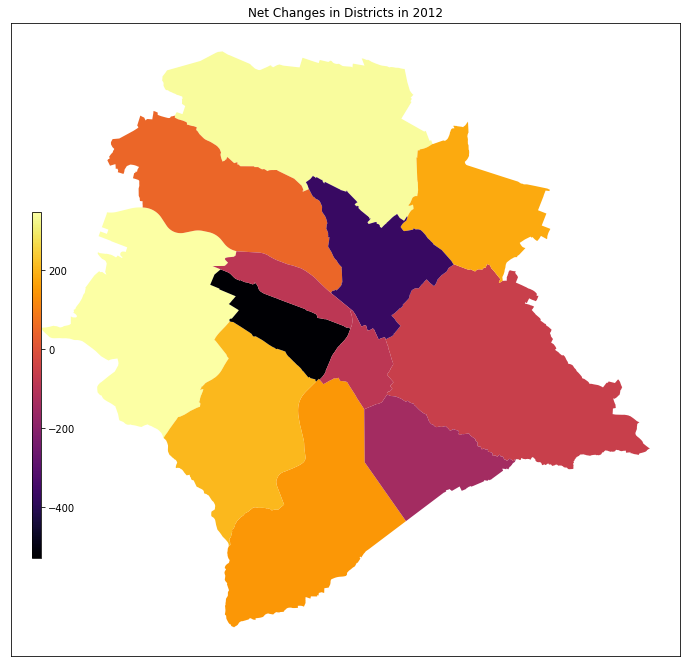

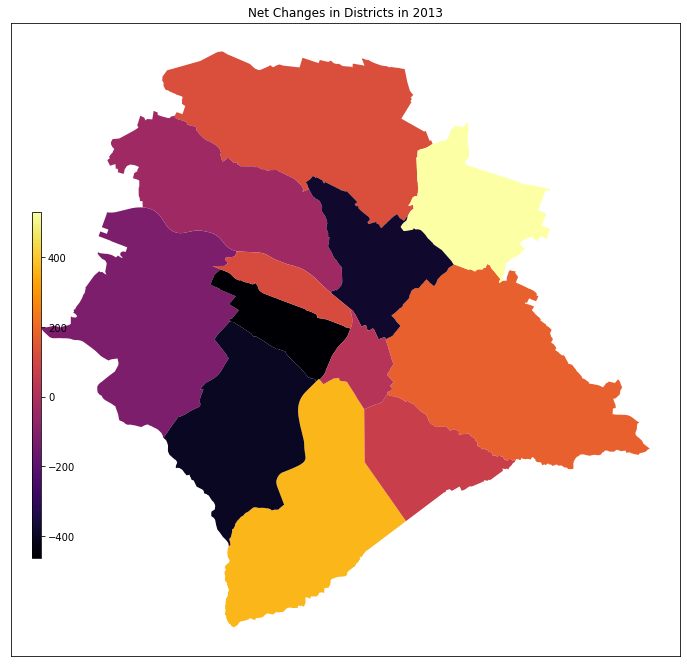

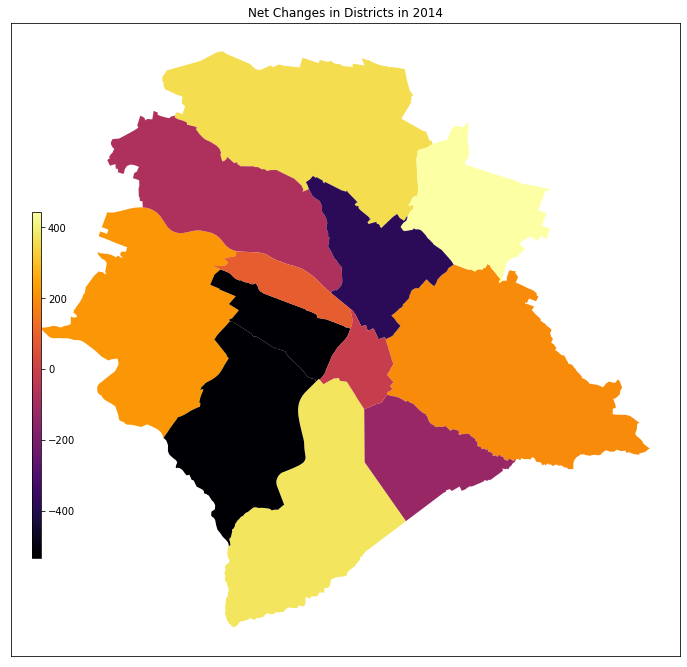

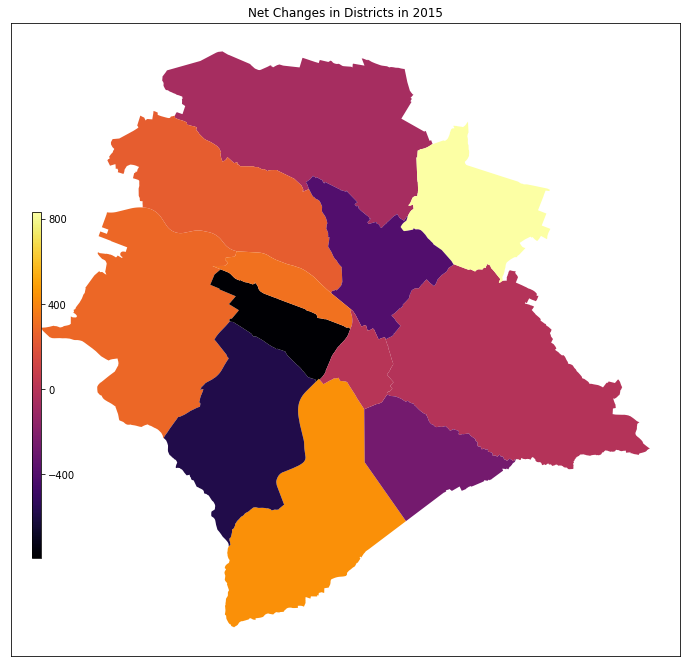

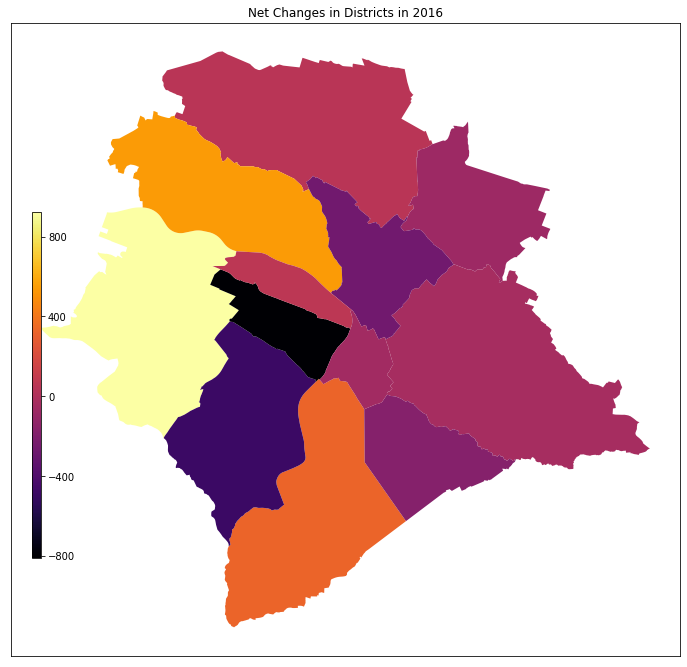

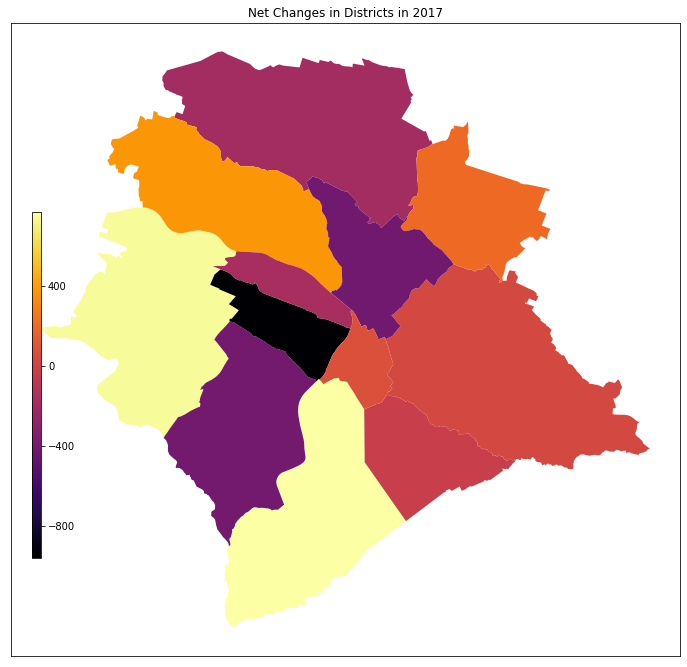

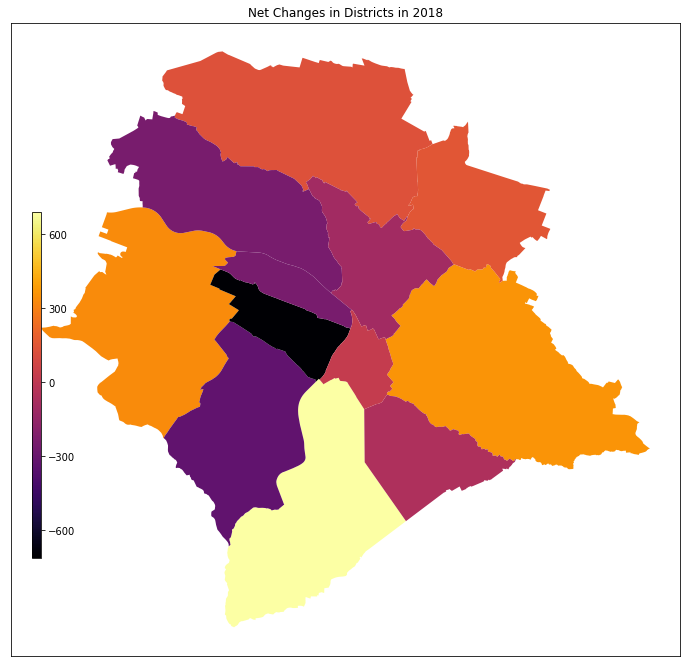

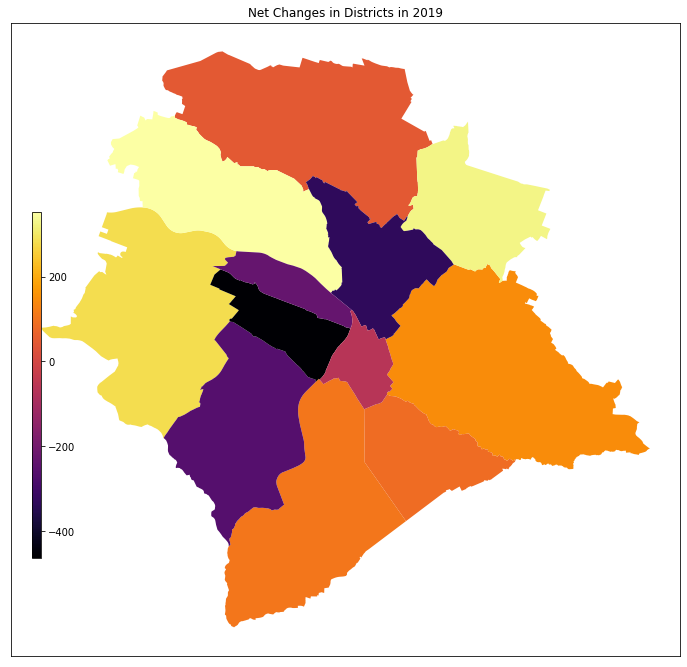

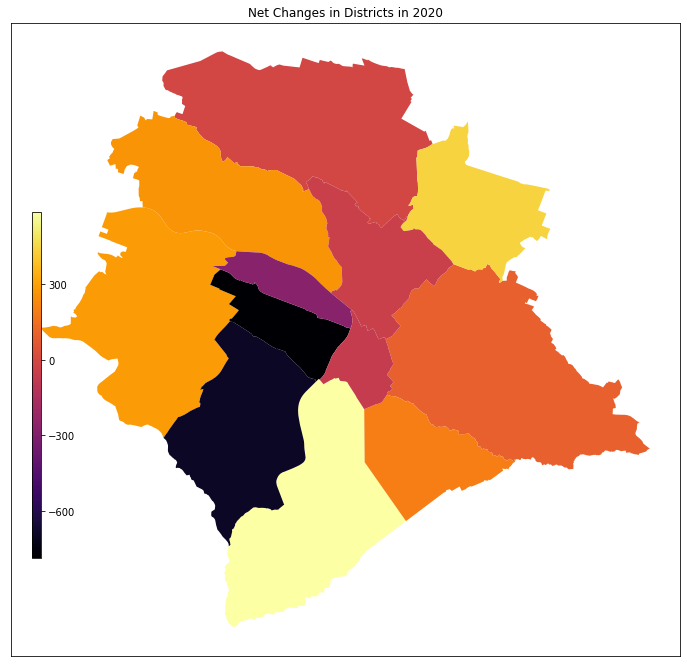

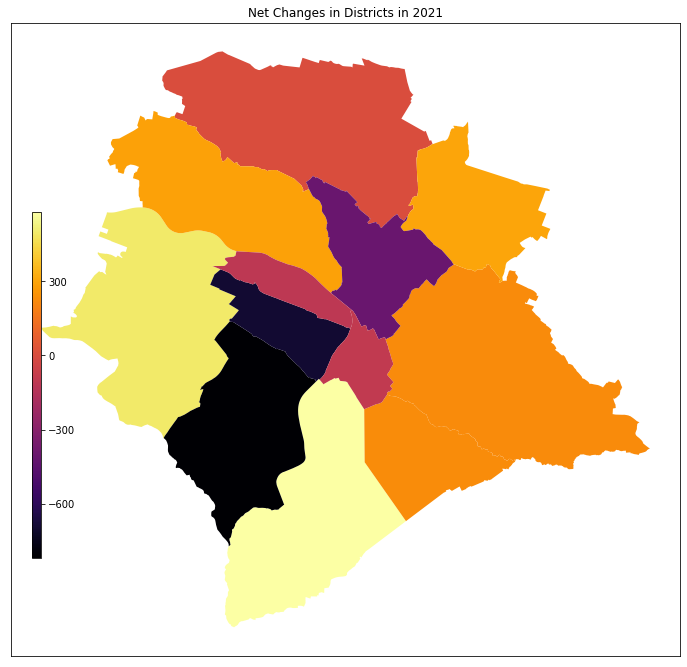

In [36]:
# For net changes of residents in each year 

df_netchange_by_year = {}
list_of_netchange_filenames = []


for year in set(df_newcomers_residents_consolidated.Year):
    
    df = df_newcomers_residents_consolidated[df_newcomers_residents_consolidated.Year == year]
    title = f"Net Changes in Districts in {year}"
    filename = f"NetChanges_in_{year}.png"
    
    plot_data_in_map_of_Zurich(df = df, 
                          column_name = 'NetChangeResidents', 
                          column_title = title,
                          filename = filename)

    list_of_netchange_filenames.append(f"./results/{filename}")

/home/michael/Dropbox/Udacity/DataScientist/MediumArticle/Zurich_Popular_Districs/blogpost-venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


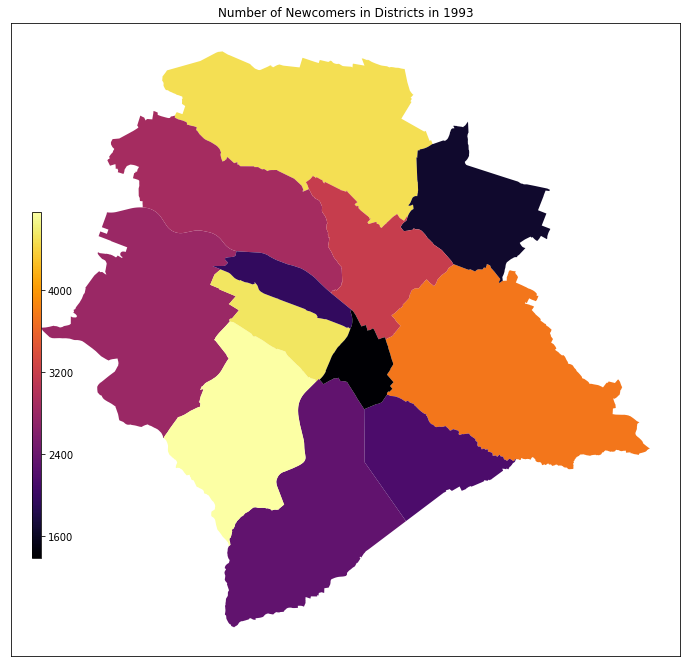

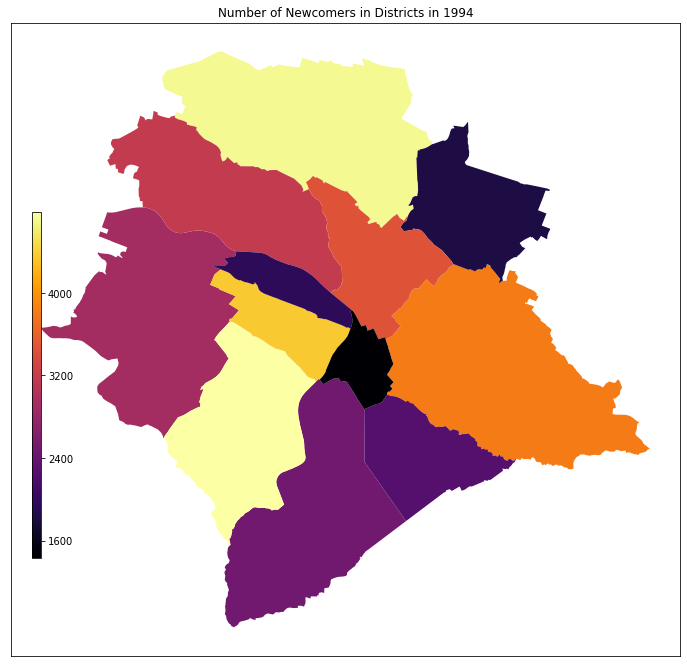

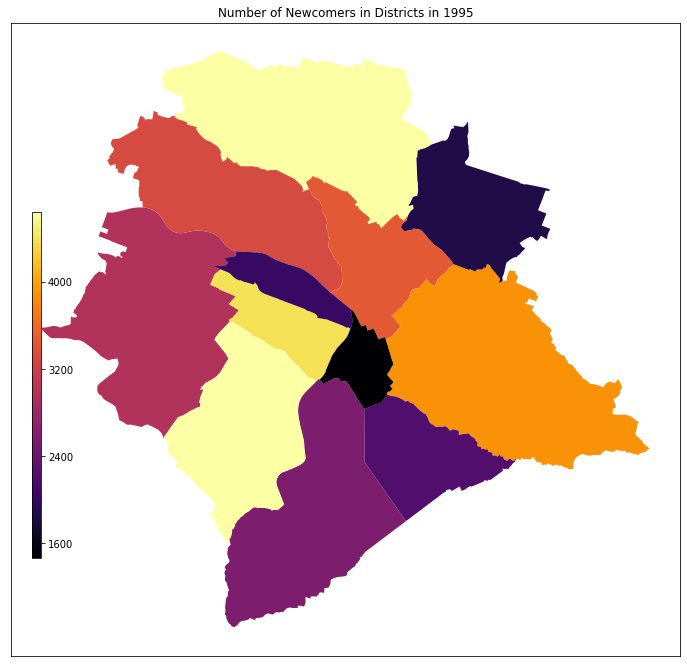

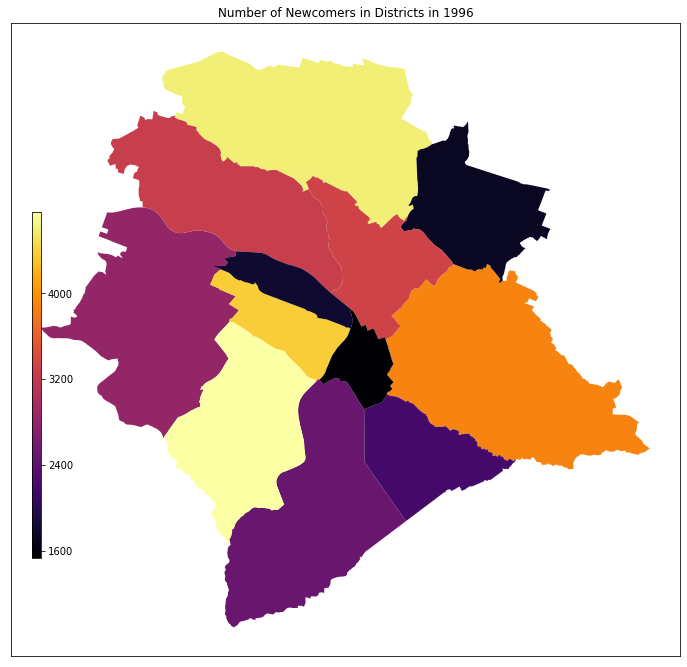

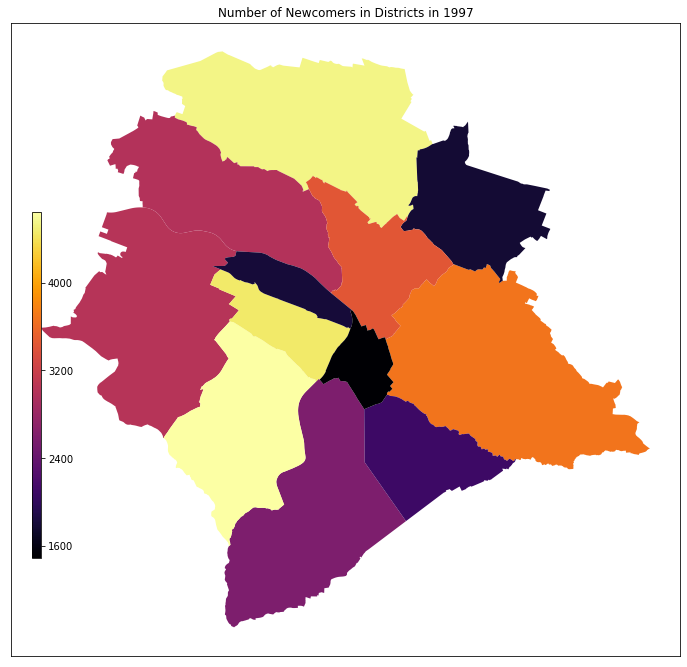

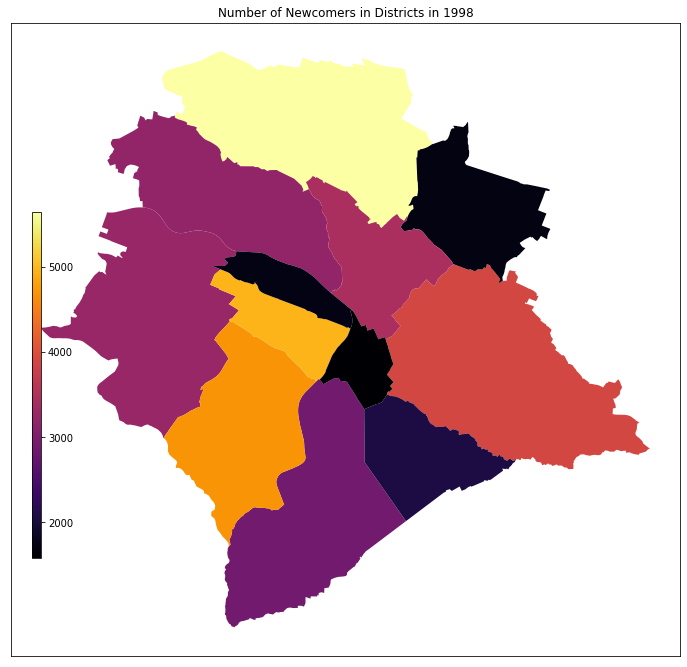

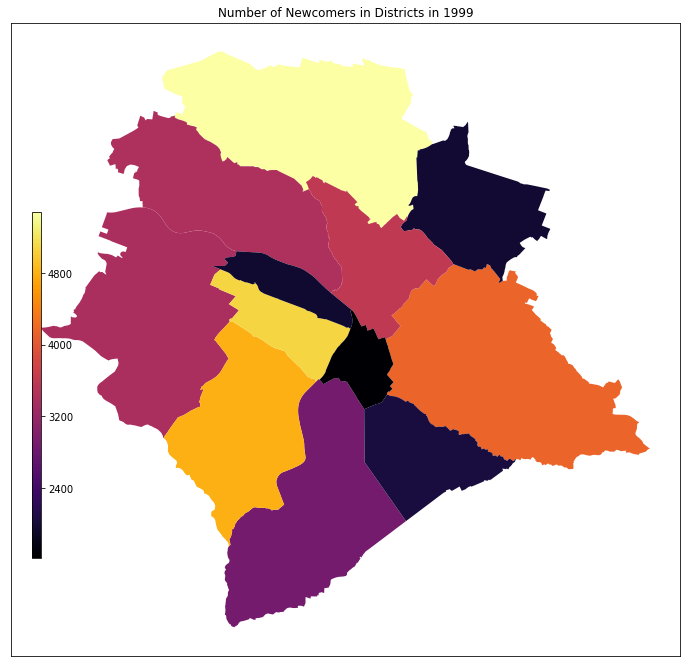

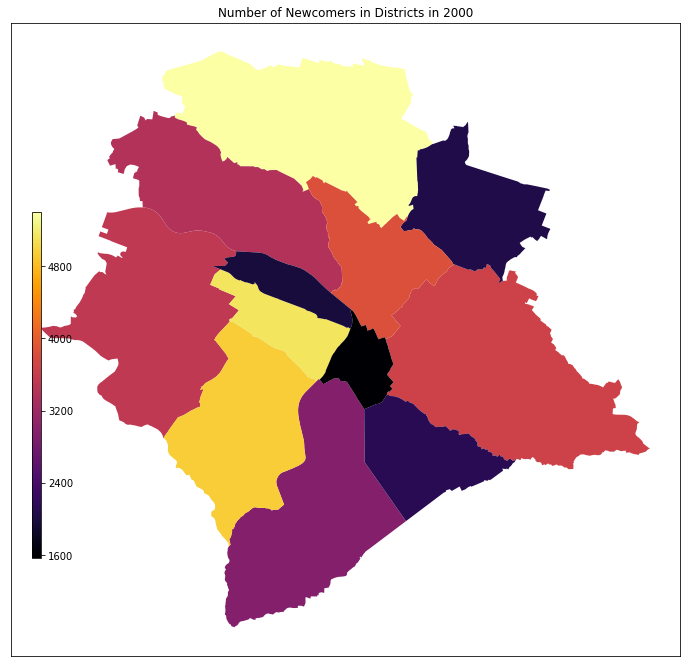

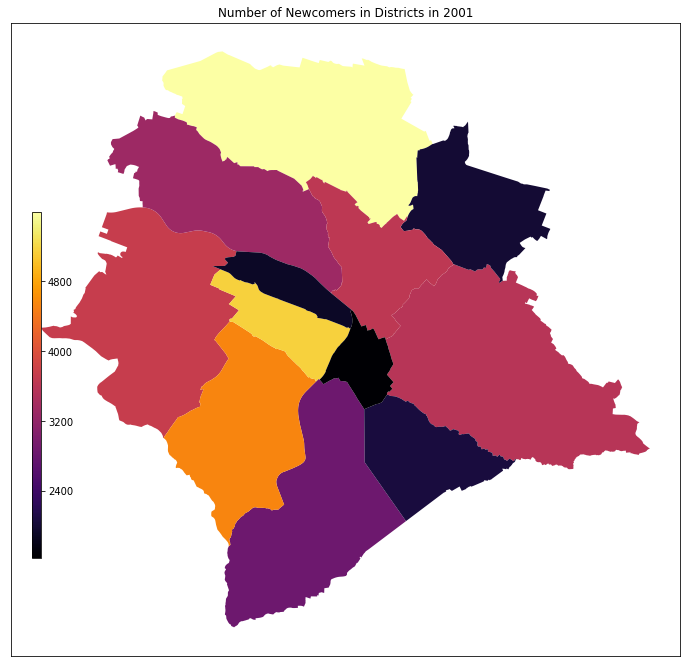

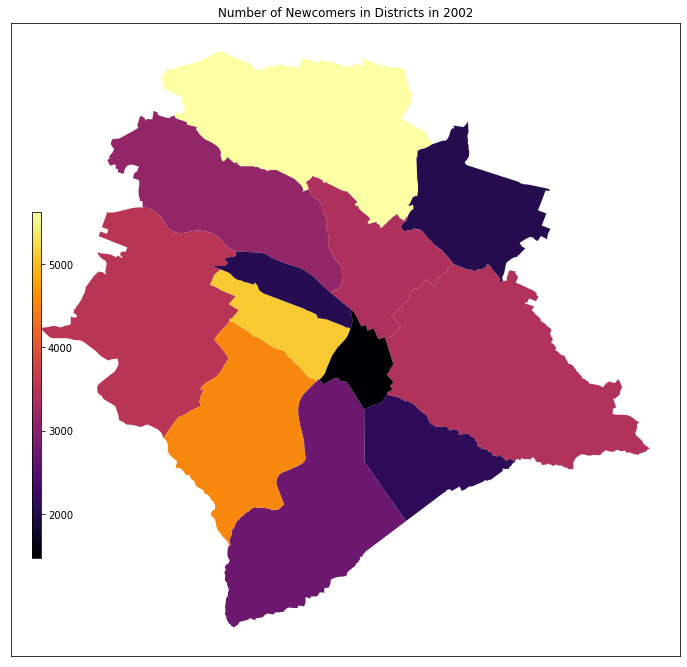

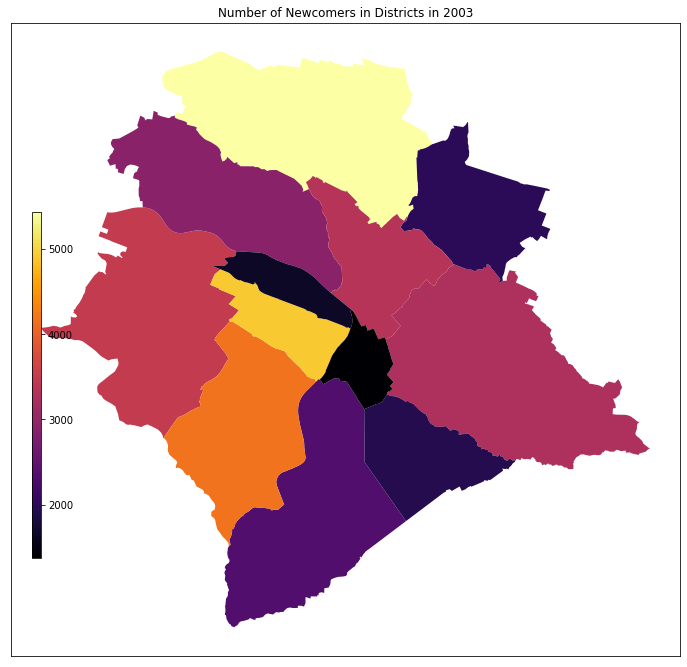

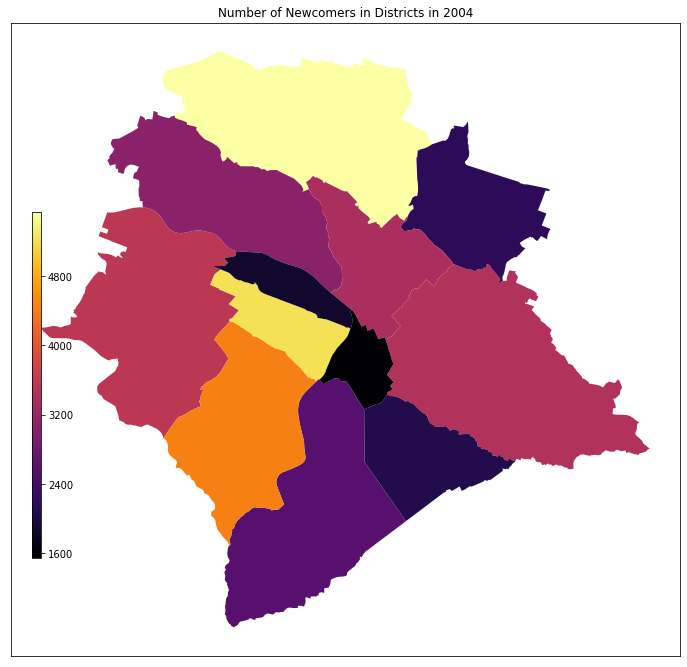

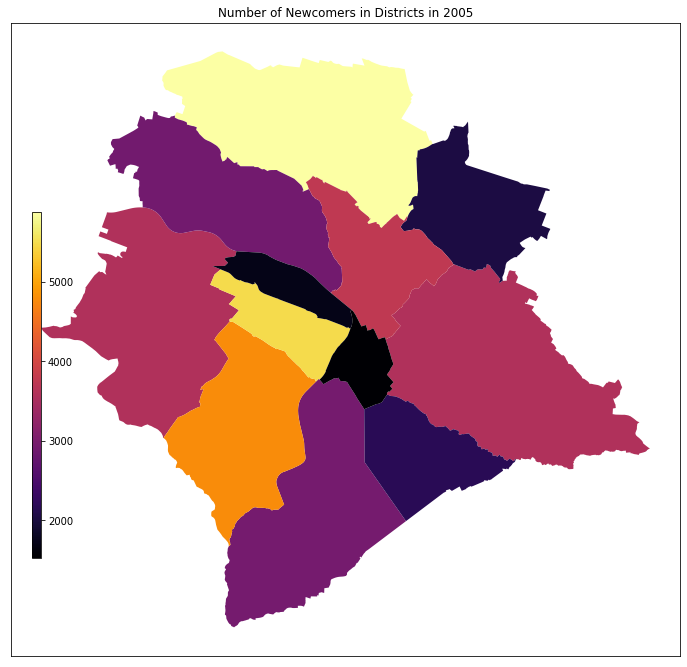

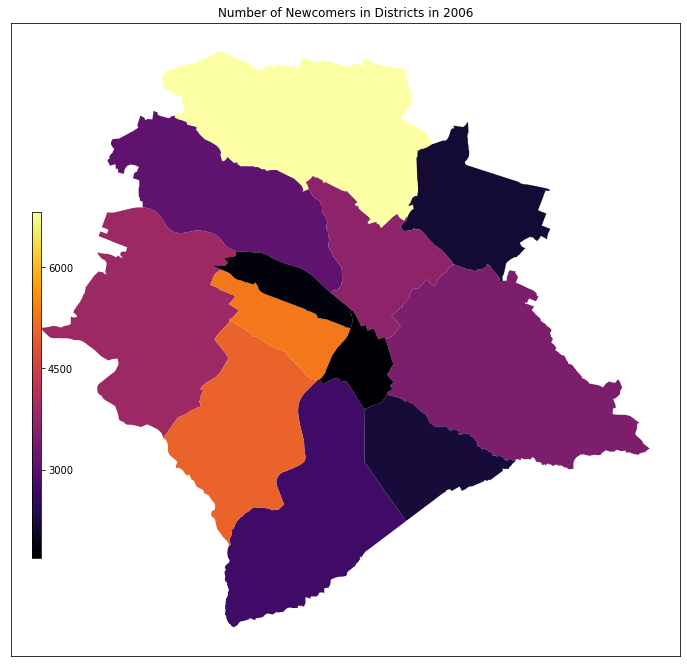

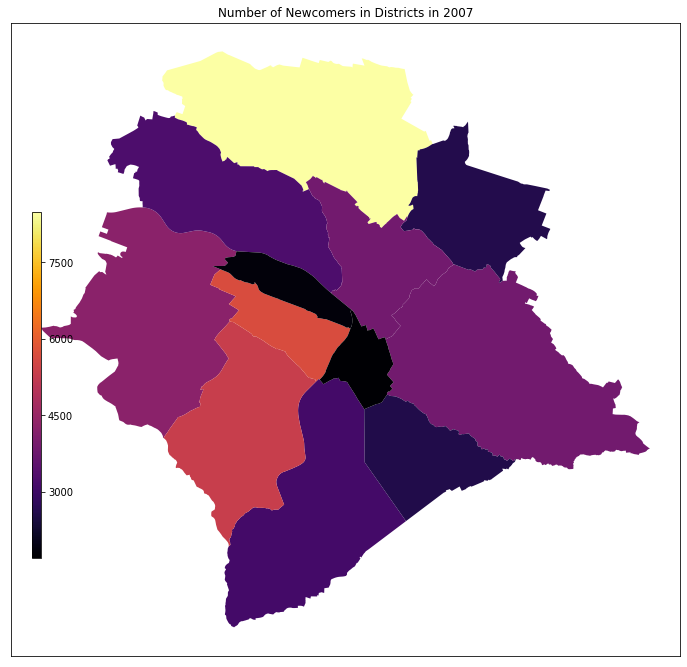

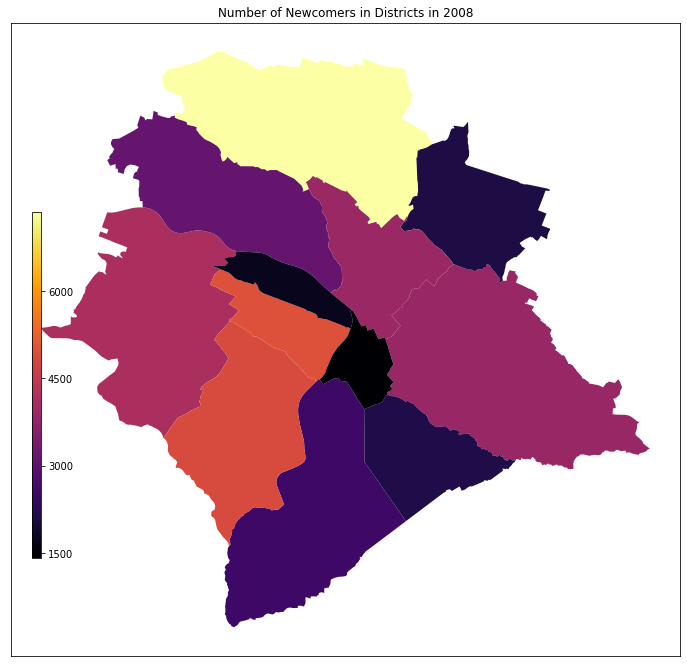

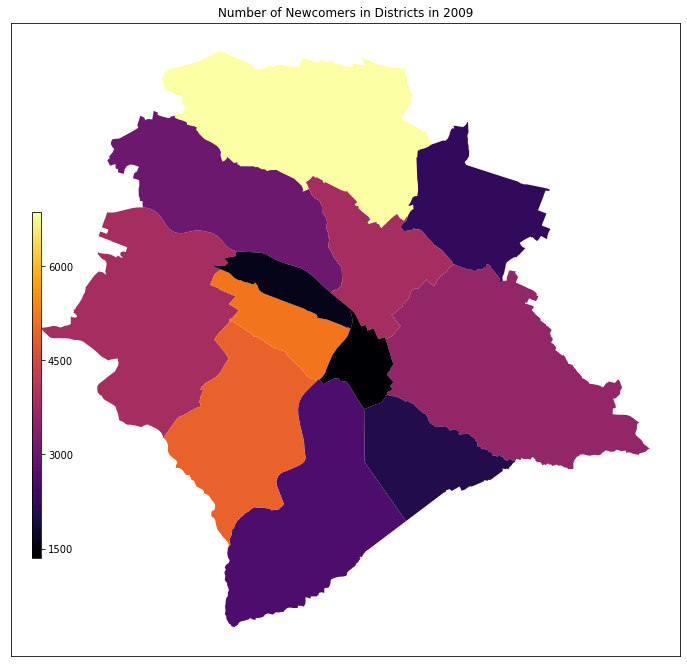

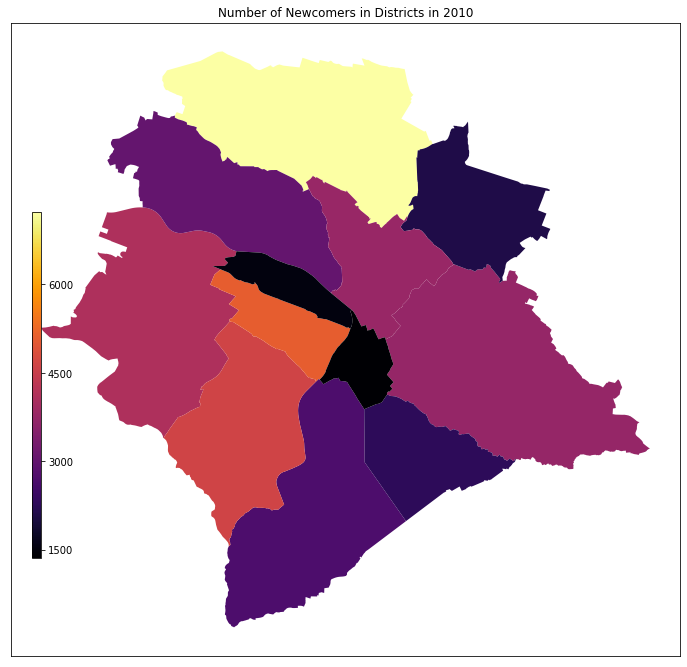

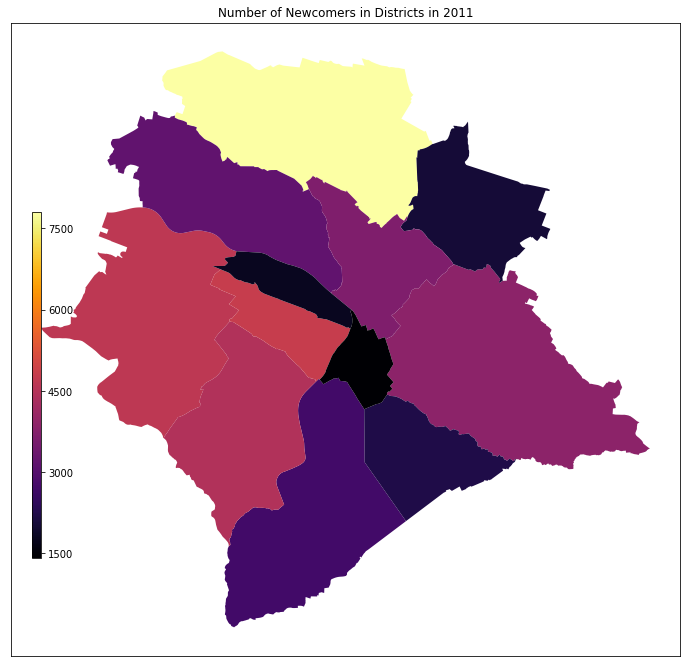

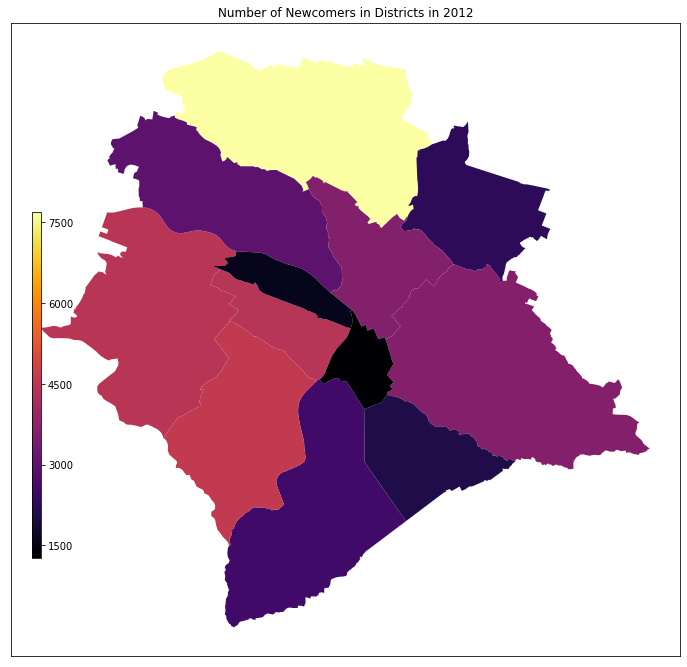

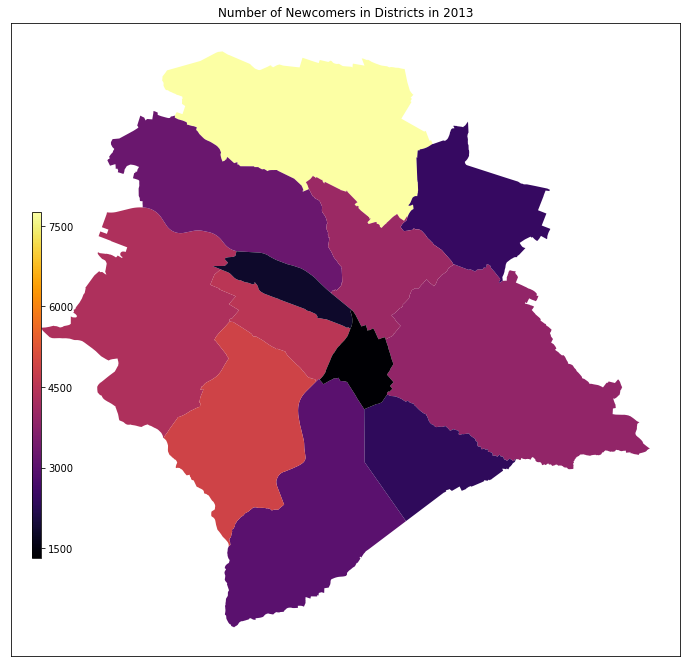

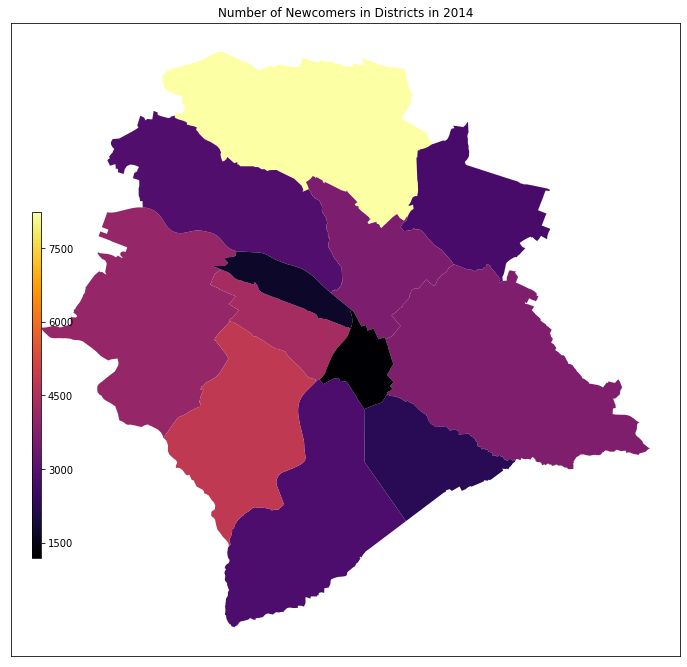

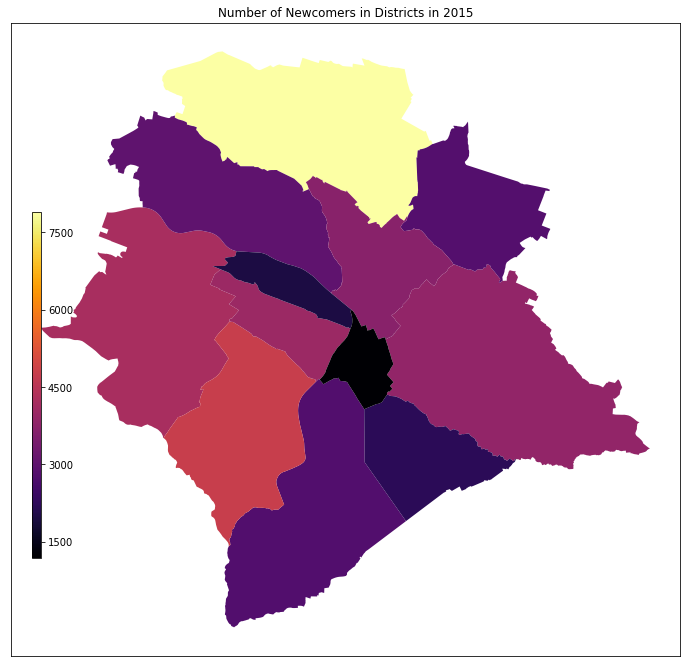

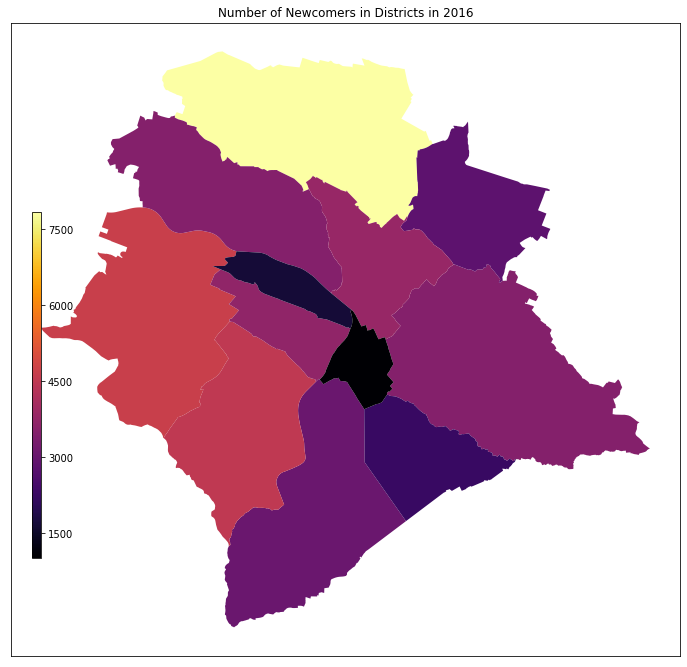

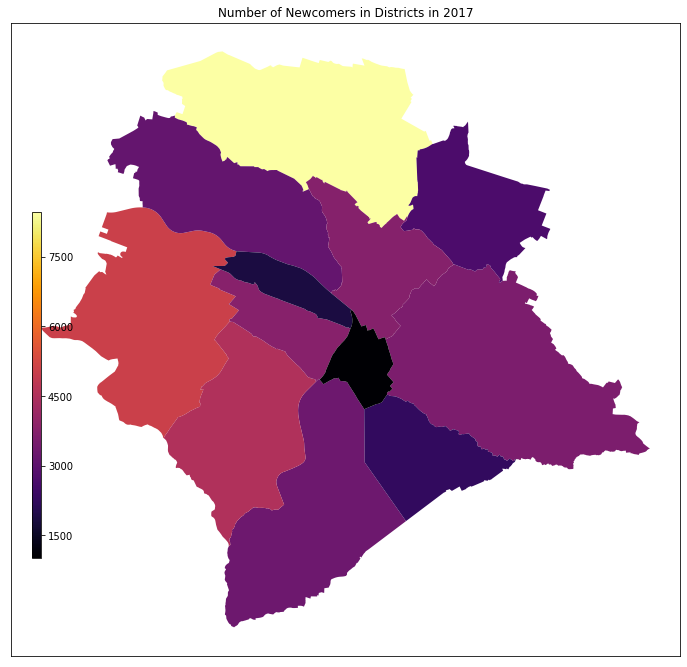

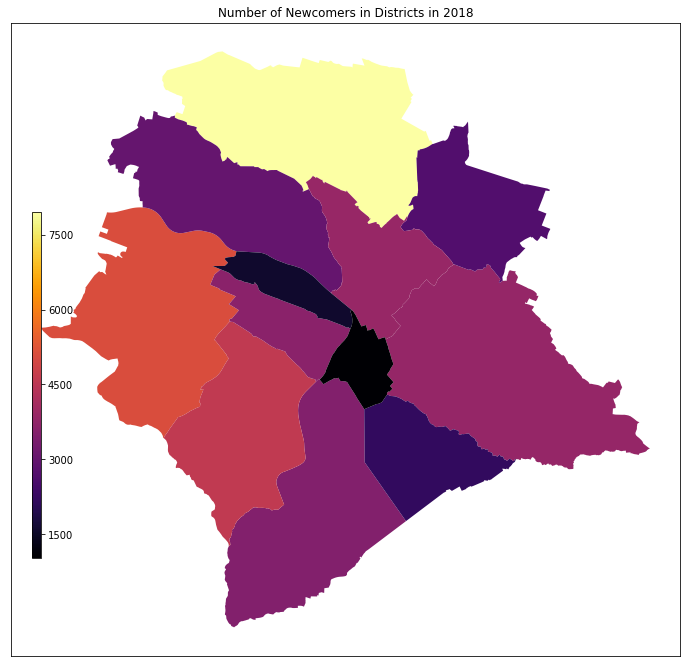

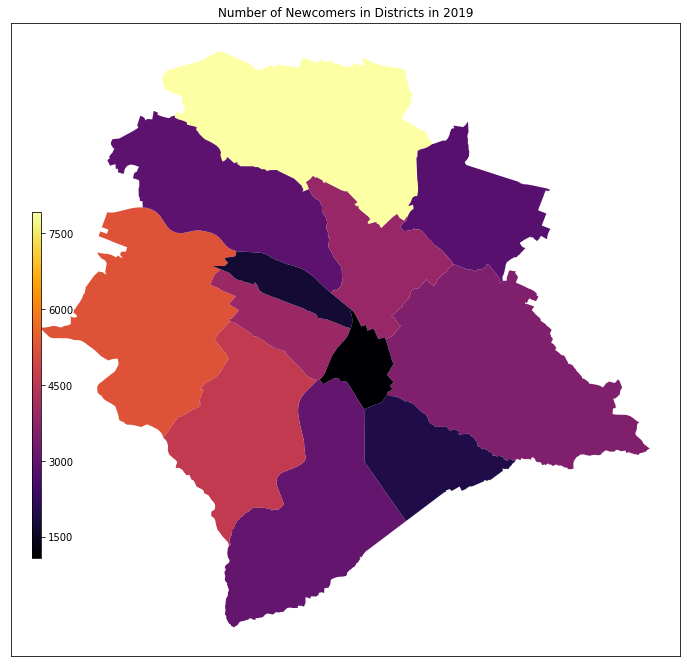

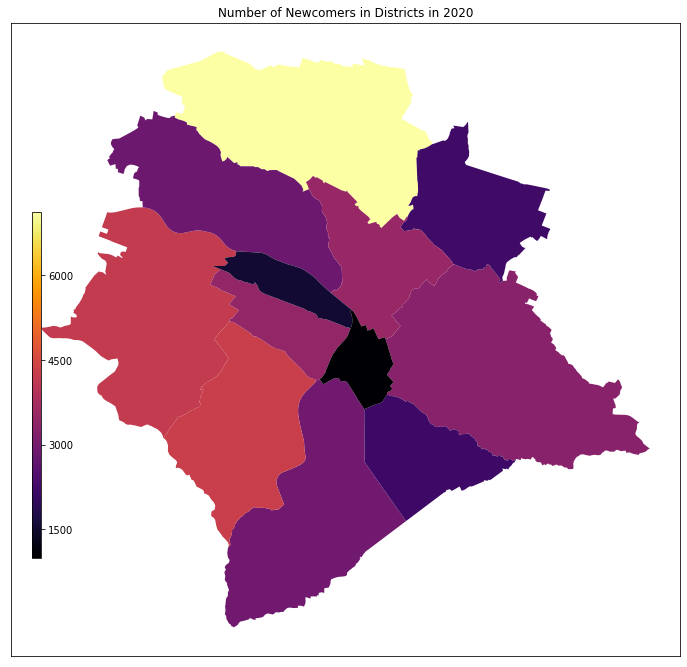

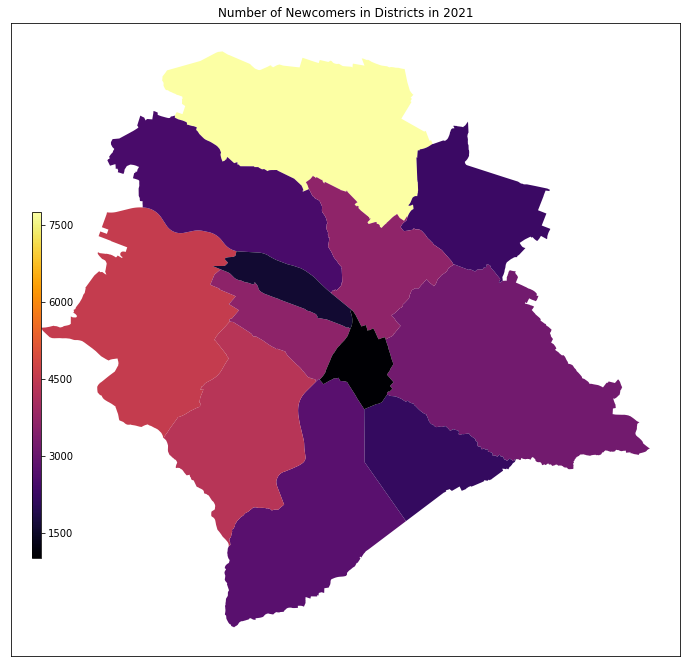

In [37]:
# For newcomer inflows in each year 

df_newcomer_by_year = {}
list_of_newcomer_filenames = []



for year in set(df_newcomers_residents_consolidated.Year):

    df = df_newcomers_residents_consolidated[df_newcomers_residents_consolidated.Year == year]
    title = f"Number of Newcomers in Districts in {year}"
    filename = f"Newcomers_in_{year}.png"
    
    plot_data_in_map_of_Zurich(df = df, 
                          column_name = 'NumberNewcomers', 
                          column_title = title,
                          filename = filename)
    
    

    list_of_newcomer_filenames.append(f"./results/{filename}")

In [38]:
# Make a GIF out of previous visualization
frames_netchanges = []
frames_newcomers = []

for filename in list_of_netchange_filenames:
    image = imageio.v2.imread(filename)
    frames_netchanges.append(image)
imageio.mimsave('./results/gif_netchanges_across_years.gif', frames_netchanges, format='GIF', duration=5)

for filename in list_of_newcomer_filenames:
    image = imageio.v2.imread(filename)
    frames_newcomers.append(image)
imageio.mimsave('./results/gif_newcomers_across_years.gif', frames_newcomers, format='GIF', duration=5)

# Exploring further: New buildings

## Question 3: Which district sees the highest number of newly built apartments

In [34]:
# Remove entries which are only approved (bewilligt) but not yet in progress
df_buildings = df_buildings[df_buildings.ProjStatus != 'Bewilligt']

# Sum the number of flats by year and district (we are not interested if a project is for business space, for example)
df_buildings_dynamic = df_buildings.groupby(['Jahr', 'KreisSort'])['ProjAnzWhg'].sum().reset_index()

df_buildings_dynamic.columns = ['Year', 'District', 'NumberOfFlats']

df_buildings_stat = df_buildings_dynamic.groupby(['District'])['NumberOfFlats'].sum().reset_index()

df_buildings_stat.style


,District,NumberOfFlats
0,1,12
1,2,10074
2,3,7372
3,4,5093
4,5,6896
5,6,5315
6,7,4225
7,8,2739
8,9,22089
9,10,5215


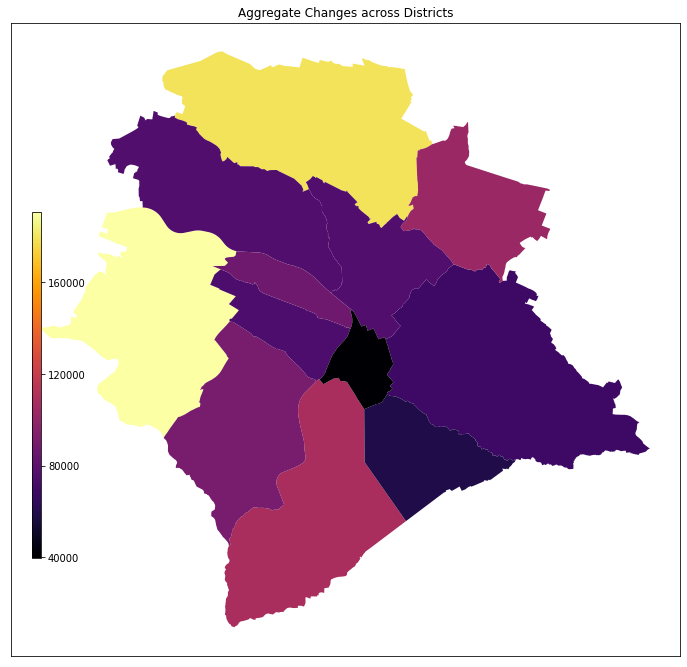

In [35]:
fig, ax = plt.subplots(1, figsize=(12, 12))
ax.set_title('Aggregate Changes across Districts')
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

df_buildings_stat_vis = geo_df.merge(df_buildings_stat, right_on='District', left_on="name")

cmap = 'inferno'
vmin = df_buildings_stat_vis['NumberOfFlats'].min()
vmax = df_buildings_stat_vis['NumberOfFlats'].max()
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)

df_buildings_stat_vis.plot(column='NumberOfFlats', ax=ax, cmap=cmap)



cbaxes = fig.add_axes([0.15, 0.25, 0.01, 0.4])
cbar = fig.colorbar(sm_netchange, cax=cbaxes)
tick_locator = ticker.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()



plt.savefig(f"./results/NewFlatsAcrossDistricts.png")
